In [26]:
from post_processing import Analysis

In [27]:
analysis = Analysis("diags202312261911")

Total particles: 440184.0


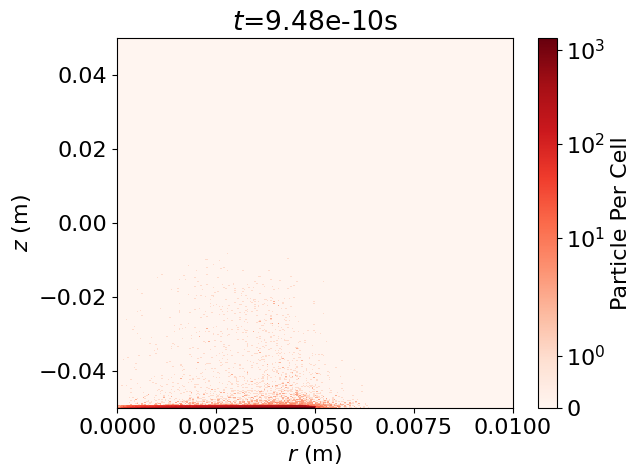

In [30]:
analysis.plot_part_per_cell(1)

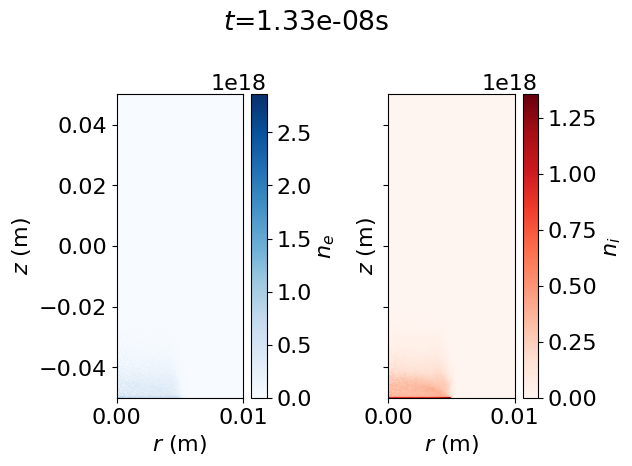

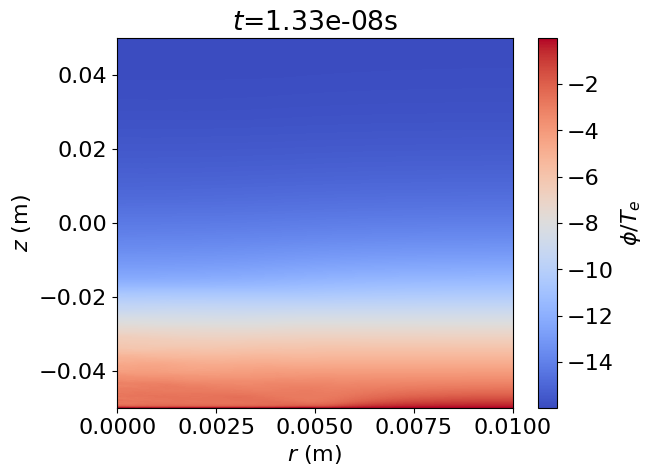

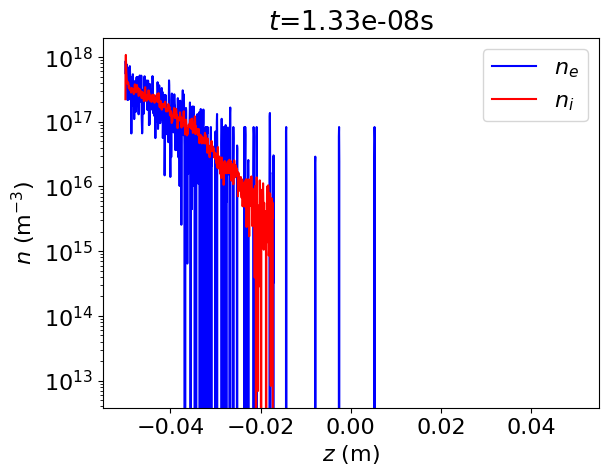

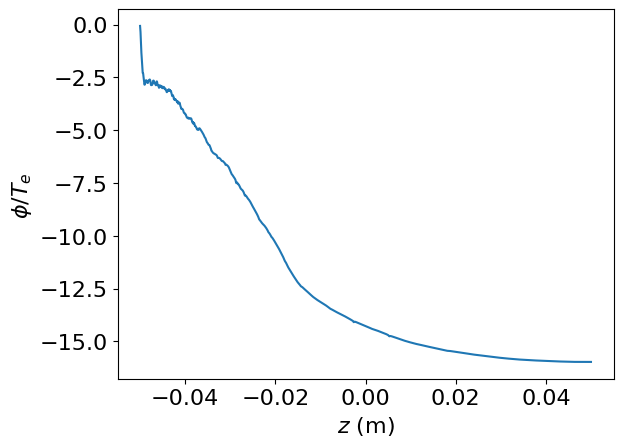

In [3]:
frame = 14
for plot_type in ["slice", "line"]:
    analysis.plot_density(frame, plot_type=plot_type)
    analysis.plot_potential(frame, plot_type=plot_type)

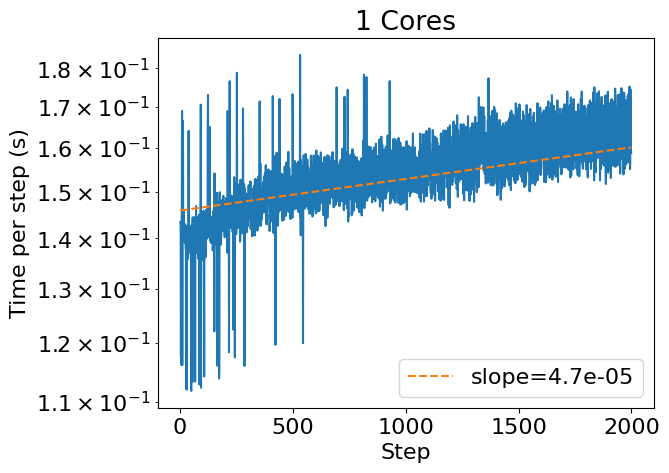

Slope is small, consider time per step as constant. 
Using linear fitting.


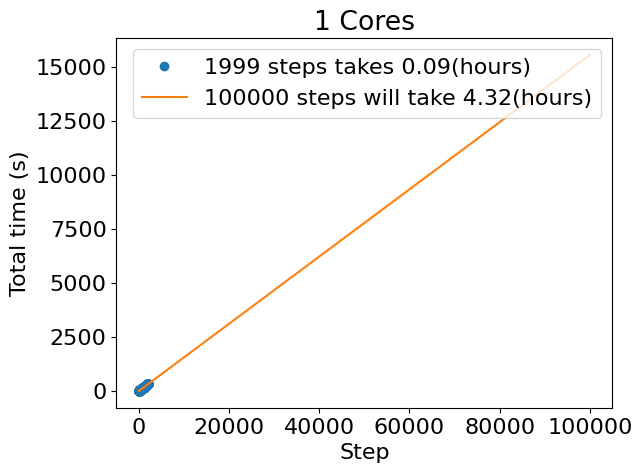

In [31]:
analysis.plot_time(100000, fitting_range=[500, 1000])

Total particles: 5890745.0


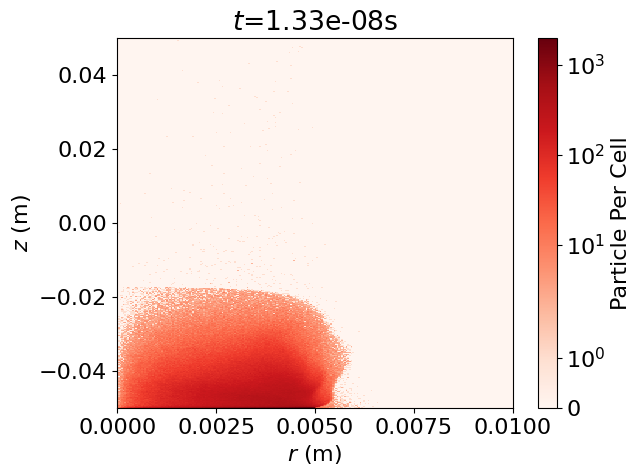

In [5]:
analysis.plot_part_per_cell(frame)